In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.stats import bootstrap
from tqdm import tqdm

# Mobile Gaming
Компания разрабатывает мобильные игры. Ряд задач по исследованию нескольких аспектов мобильного приложения:

1. В первую очередь, его интересует показатель retention. Напишем функцию для его подсчета.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определим, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. Предложим метрики для оценки результатов последнего прошедшего тематического события в игре.
 
### Задание 1
Retention – один из самых важных показателей в компании. Задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

Выгрузим и ознакомимся с данными.

In [2]:
path_reg_data = '~/projects/problem1-reg_data.csv'
path_auth_data = '~/projects/problem1-auth_data.csv'

In [3]:
reg_data = pd.read_csv(path_reg_data, sep=';')
auth_data = pd.read_csv(path_auth_data, sep=';')

In [4]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [5]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [6]:
reg_data.shape

(1000000, 2)

In [7]:
reg_data.nunique()

reg_ts    1000000
uid       1000000
dtype: int64

In [8]:
reg_data.isnull().sum()

reg_ts    0
uid       0
dtype: int64

In [9]:
pd.to_datetime(reg_data.reg_ts.agg(['min', 'max']), unit='s').dt.date 

min    1998-11-18
max    2020-09-23
Name: reg_ts, dtype: object

In [10]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [11]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [12]:
auth_data.shape

(9601013, 2)

In [13]:
auth_data.nunique()

auth_ts    9180915
uid        1000000
dtype: int64

In [14]:
auth_data.isnull().sum()

auth_ts    0
uid        0
dtype: int64

In [15]:
pd.to_datetime(auth_data.auth_ts.agg(['min', 'max']), unit='s').dt.date 

min    1998-11-18
max    2020-09-23
Name: auth_ts, dtype: object

В данных нет нулевых значений, информация представлена об 1.000.000 уникальных пользователей, что позволяет нам объединить датафреймы.
Данные представлены за довольно большой промежуток времени (22 года). 

Так как по условию нужно написать функцию, которая считает retention по дням от даты регестрации игрока, а временной отрезок у нас 
довольно большой, сделаем функцию, которая на входе принимает данные для вычисления retention за определенный период. Для большей наглядности и информативности функция будет выводить таблицу по абсолютному количеству пользователей и heatmap в процентном отношении. 

На вход функция принимает значения:  
**reg_path** - путь до файла с данными о времени регистрации;  
**auth_path** - путь до файла с данными о времени захода пользователей в игру;  
**from_date** - дату начала интервала в формате string 'yyyy-mm-dd';  
**to_date** - дату окончания интервала в формате string 'yyyy-mm-dd'.   

In [16]:
def retention(reg_path, auth_path, from_date, to_date):
    
    reg_df = pd.read_csv(reg_path, sep=';')
    auth_df = pd.read_csv(auth_path, sep=';')
    
    reg_df['reg_date'] = pd.to_datetime(reg_df.reg_ts, unit='s').dt.date
    auth_df['auth_date'] = pd.to_datetime(auth_df.auth_ts, unit='s').dt.date
    
    from_date = datetime.strptime(from_date, '%Y-%m-%d').date()
    to_date = datetime.strptime(to_date, '%Y-%m-%d').date()
    
    retention_df = auth_df.merge(reg_df, how='left', on='uid')
    retention_df['days_diff'] = (retention_df.auth_date - retention_df.reg_date).dt.days
    
    retention_df = retention_df.query("reg_date>=@from_date and reg_date<=@to_date \
                                       and auth_date>=@from_date and auth_date<=@to_date").\
    groupby(['reg_date', 'days_diff']).agg({'uid':'nunique'}).\
    reset_index().pivot(index='reg_date', columns='days_diff', values='uid')
    
    plt.figure(figsize = (25,15))
    sns.heatmap(data=retention_df.divide(retention_df[0], axis=0).round(4),  annot=True, linewidth=0.5,
                vmax = retention_df.divide(retention_df[0], axis=0).round(4).drop(columns = {0}).max().max(),
                linecolor ='black', fmt=".2%", cmap='coolwarm')
    
    return retention_df

days_diff,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
reg_date,,,,,,,,,,,,,,,,,,,,,
2020-02-14,1141.0,17.0,57.0,57.0,61.0,66.0,80.0,62.0,49.0,57.0,...,43.0,46.0,36.0,41.0,31.0,40.0,35.0,32.0,37.0,26.0
2020-02-15,1143.0,19.0,42.0,47.0,59.0,65.0,74.0,74.0,48.0,53.0,...,35.0,37.0,36.0,38.0,34.0,43.0,30.0,37.0,27.0,NaN
2020-02-16,1145.0,21.0,42.0,46.0,59.0,79.0,82.0,78.0,46.0,61.0,...,44.0,49.0,44.0,34.0,31.0,56.0,41.0,34.0,NaN,NaN
2020-02-17,1147.0,30.0,43.0,49.0,57.0,65.0,72.0,80.0,58.0,58.0,...,44.0,53.0,56.0,28.0,37.0,33.0,41.0,NaN,NaN,NaN
2020-02-18,1149.0,29.0,54.0,49.0,46.0,71.0,83.0,55.0,60.0,60.0,...,41.0,42.0,48.0,50.0,31.0,35.0,NaN,NaN,NaN,NaN
2020-02-19,1150.0,27.0,50.0,39.0,49.0,51.0,71.0,52.0,50.0,43.0,...,37.0,31.0,36.0,48.0,42.0,NaN,NaN,NaN,NaN,NaN
2020-02-20,1153.0,22.0,47.0,48.0,64.0,69.0,83.0,75.0,64.0,53.0,...,52.0,47.0,48.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-21,1154.0,26.0,41.0,50.0,67.0,67.0,77.0,69.0,62.0,54.0,...,36.0,51.0,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-22,1157.0,20.0,53.0,54.0,61.0,73.0,65.0,65.0,52.0,60.0,...,47.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


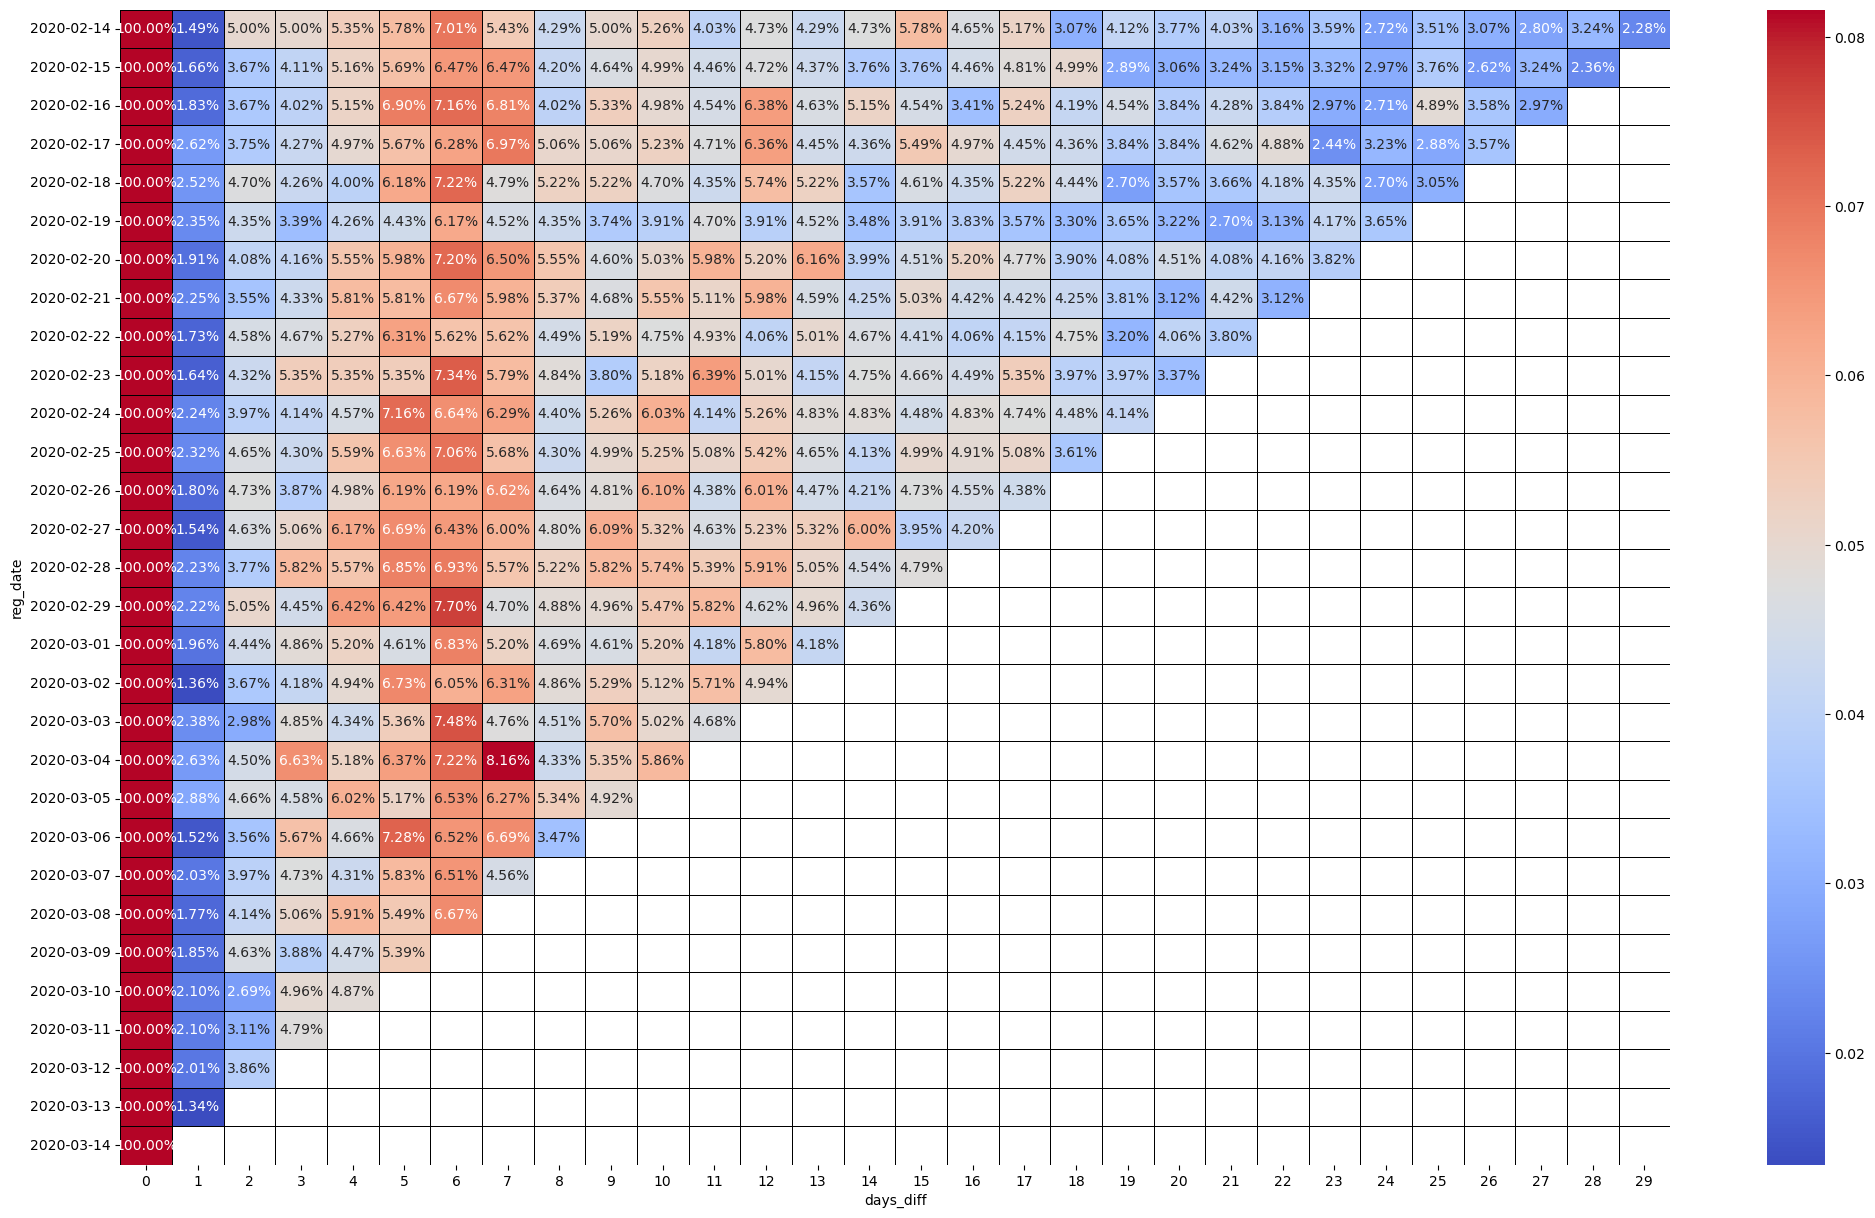

In [17]:
retention(path_reg_data, path_auth_data, '2020-02-14', '2020-03-14')

### Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Выгрузим и ознакомимся с данными.

In [18]:
df = pd.read_csv('~/projects/prom_test.csv', sep=';')

In [19]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [20]:
df.groupby('testgroup').describe()

user_id                                                         \
              count           mean            std  min       25%       50%   
testgroup                                                                    
a          202103.0  202555.909843  116802.329266  2.0  101502.5  202988.0   
b          202667.0  202215.564389  116891.926690  1.0  100855.5  201821.0   

                                revenue                                        \
                75%       max     count       mean         std  min  25%  50%   
testgroup                                                                       
a          303559.0  404769.0  202103.0  25.413720  920.768137  0.0  0.0  0.0   
b          303602.5  404770.0  202667.0  26.751287  287.324162  0.0  0.0  0.0   

                         
           75%      max  
testgroup                
a          0.0  37433.0  
b          0.0   4000.0

In [21]:
df.shape

(404770, 3)

In [22]:
df.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

In [23]:
df.isnull().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [24]:
group_a= df.query("testgroup=='a'")

In [25]:
group_b= df.query("testgroup=='b'")

In [26]:
round(100 - group_a.revenue.mean() *100/group_b.revenue.mean(), 2) 

5.0

In [27]:
group_a.query('revenue>0').describe()

,user_id,revenue
count,1928.000000,1928.000000
mean,200152.677905,2663.998444
std,116596.504905,9049.039763
min,73.000000,200.000000
25%,99323.000000,257.000000
50%,199854.500000,311.000000
75%,299664.250000,361.000000
max,404768.000000,37433.000000


In [28]:
group_b.query('revenue>0').describe()

,user_id,revenue
count,1805.000000,1805.000000
mean,205834.548476,3003.658172
std,116400.045485,572.619709
min,161.000000,2000.000000
25%,106815.000000,2513.000000
50%,206651.000000,3022.000000
75%,304907.000000,3478.000000
max,404526.000000,4000.000000


/Users/SANYA/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/SANYA/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


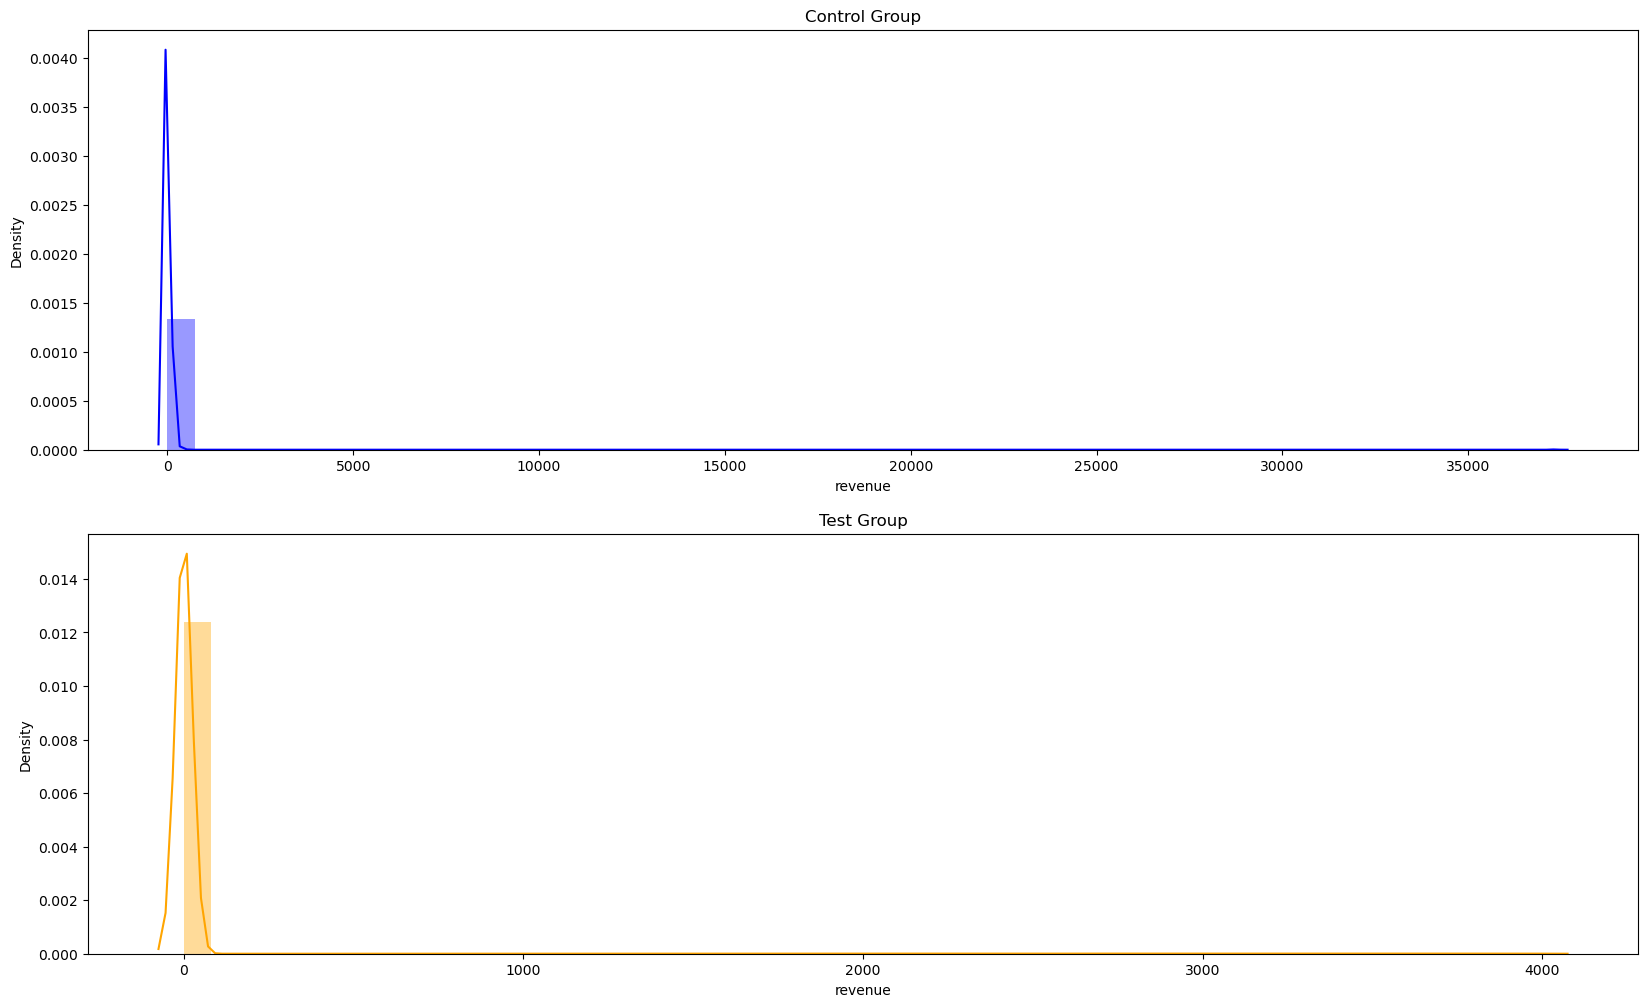

In [29]:
plt.figure(figsize=(20, 12))

plt.subplot(2, 1, 1)
sns.distplot(group_a.revenue, color = 'blue')
plt.title("Control Group")

plt.subplot(2, 1, 2)
sns.distplot(group_b.revenue, color = 'orange')
plt.title("Test Group")

plt.show()

/Users/SANYA/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/SANYA/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


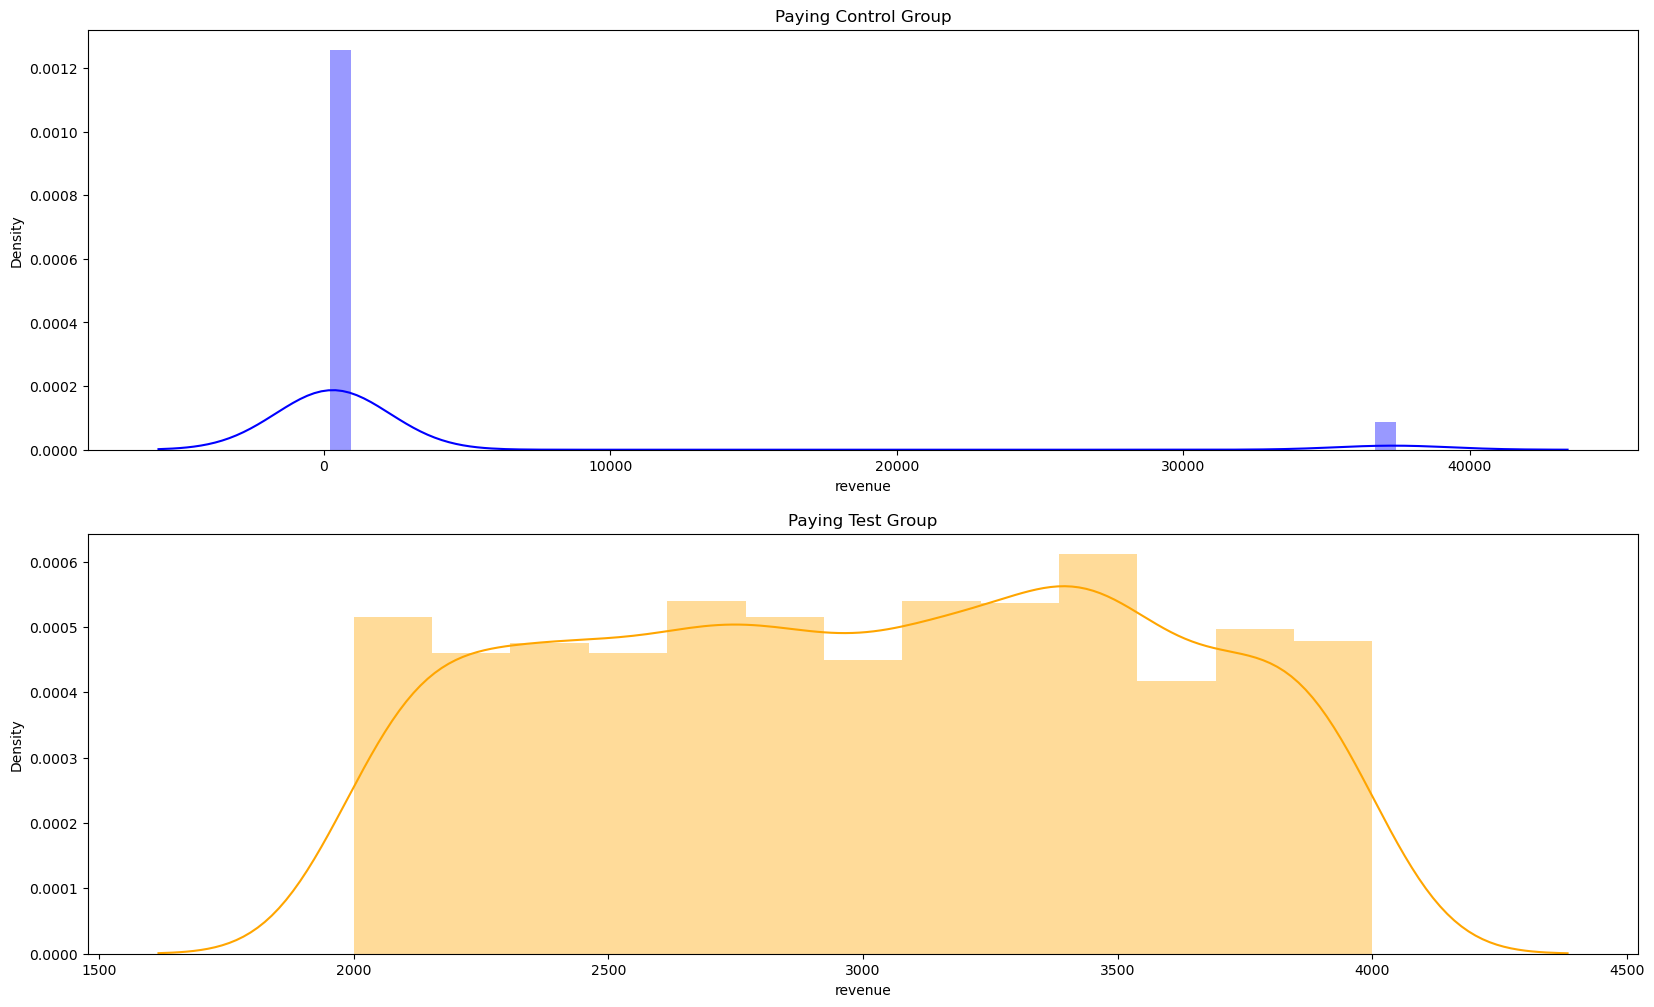

In [30]:
plt.figure(figsize=(20, 12))

plt.subplot(2, 1, 1)
sns.distplot(group_a.query('revenue>0').revenue, color = 'blue')
plt.title("Paying Control Group")

plt.subplot(2, 1, 2)
sns.distplot(group_b.query('revenue>0').revenue, color = 'orange')
plt.title("Paying Test Group")

plt.show()

In [31]:
print(ss.normaltest(group_a.query('revenue>0').revenue))
print(ss.normaltest(group_b.query('revenue>0').revenue))

NormaltestResult(statistic=1394.9457843086925, pvalue=1.2341605505935488e-303)
NormaltestResult(statistic=1068.8600084412267, pvalue=7.943249488371762e-233)


In [32]:
ss.levene(group_a.query('revenue>0').revenue, group_b.query('revenue>0').revenue)

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

В данных нет нулевых значений, количество уникальных пользователей равно количество строк (404770).

Минимальное и максимальное значение в двух группах сильно отличается, что может говорить о проблеме в сплитовании. ARPU в тестовой платящей группе выше на 5%, чем в контрольной, как и говорилось в задаче. Среднеквадратичное отклонение в двух группах также отличается, разброс в контрольной группе намного больше, чем в тестовой. 

Большая часть пользователей приходится на неплатящих, имеются значительные выбросы, целесообразнее будет работать с платящими пользователями. В графиках с платящими пользователями в тестовой группе распределение относительное равномерное, в то время как в контрольной группе распределение больше напоминает бимодальное. 

Проведя проверку на нормальность выяснили, что распределения не являются нормальными, т.к. p-value<0,05 - отклоняем нулевую гипотезу. А также с помощью теста Бартлетта определили, что группы имеют разные дисперсии, т.к. p-value<0,05 - отклоняем нулевую гипотезу. 

#### *Для анализа расчитаем несколько метрик для тестовой и контрольной групп, а точнее:*

ARPU (Average revenue per user) - cредний доход с привлечённого пользователя.

ARPPU (Average revenue per paying user) - cредний доход на платящего пользователя (то есть клиента). Состоит из того, насколько часто пользователь покупает, и насколько большой средний чек покупки.

CR (Conversion rate) - отношение числа клиентов, к общему числу пользователей.

In [33]:
ARPU = df.groupby('testgroup', as_index=False)\
         .agg({'revenue':'mean'}).rename(columns={'revenue':'ARPU'})
ARPU

,testgroup,ARPU
0,a,25.413720
1,b,26.751287


In [34]:
ARPPU = df.query('revenue>0').groupby('testgroup', as_index=False)\
          .agg({'revenue':'mean'}).rename(columns={'revenue':'ARPPU'})
ARPPU

,testgroup,ARPPU
0,a,2663.998444
1,b,3003.658172


In [35]:
CR = df.query('revenue>0').groupby('testgroup', as_index=False)\
       .agg({'user_id':'count'})
CR['CR'] = round(CR.user_id/df.groupby('testgroup', as_index=False)\
           .agg({'user_id':'count'}).user_id*100,2)
CR = CR[['testgroup', 'CR']]
CR

,testgroup,CR
0,a,0.95
1,b,0.89


Применение t-теста нам не подходит, далеко не факт, что он сработает корректно, так как должны соблюдаться условия:  
1. Требование к нормальности данных обеих групп; 
2. Требование гомогенности дисперсий.

Поэтому воспользуемся методом bootstrap для выявления статистически значимых различий между группами по метрикам ARPU/ARPPU, 
для выявления статистически значимых различий по метрике CR воспользуемся критерием Пирсона, так как имеем категориальные данные, где 0-неплатящие пользователи, 1-платящие.

__Сформулируем гипотезы.__  
*По критерию Пирсона:*  
Н0 - распределение не зависит от группы.  
Н1 - между группами имеются значимые различия.  
*Bootstrap:*  
Н0 - статистически значимых различий нет.  
Н1 - между группами имеются значимые различия.



In [36]:
df["code"] = np.where(df["revenue"]>0, 1, 0)
chi2_df = pd.crosstab(df.testgroup,df.code)
chi2_df

code,0,1
testgroup,,
a,200175,1928
b,200862,1805


In [37]:
ss.chi2_contingency(chi2_df)[:2]

(4.374729521260405, 0.03647561892312613)

Нулевая гипотеза утверждает, что доля платящих пользователей не зависит от группы, так как мы получили p-value=0,037 - отклоняем нулевую гипотезу. Принимаем гипотезу о том, что конверсия между группами имеет существенные различия. Конверсия в контрольной группе выше. 

In [38]:
def get_bootstrap(
    control_data, # числовые значения первой выборки
    test_data, # числовые значения второй выборки
    boot_it = 10000, # количество симуляций
    statistic = np.mean, # функция, которая считает нужный нам параметр
    bootstrap_conf_level = 0.95 # уровень значимости, по умолчанию 95%
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = control_data.sample(
            len(control_data), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = test_data.sample(
            len(control_data), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = ss.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = ss.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('orange')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    
    print(f'Доверительный интервал: [{quants.values[0][0].round(2)}, {quants.values[1][0].round(2)}]')
    print(f'Р-уровень значимости: {round(p_value, 2)}')
       
    return {"boot_data": boot_data,
            "quants": quants, 
            "p_value": p_value}

Проверим статистически ли значимы различия между группами по метрике ARPU. 

100%|█████████████████████████████████████| 10000/10000 [01:53<00:00, 88.14it/s]


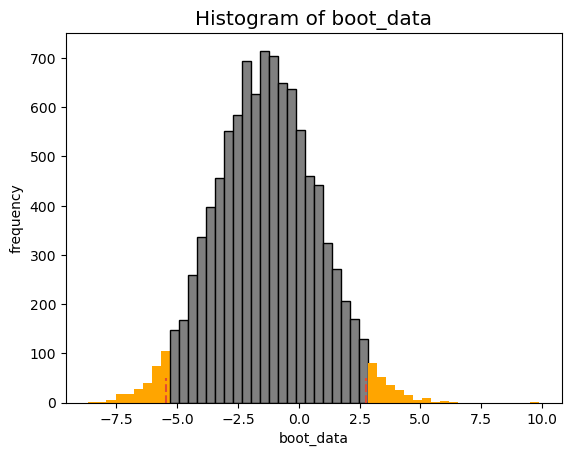

Доверительный интервал: [-5.44, 2.78]
Р-уровень значимости: 0.52


In [39]:
ARPU_bootstrap = get_bootstrap(group_a.revenue, group_b.revenue)

Результат показал, что p-value>0,05, что означает, что мы не можем отвергнуть нулевую гипотезу. Делаем вывод, что средний доход с привлеченного ползователя между групп не имеет стат значимого различия. 

Проверим статистически ли значимы различия между группами по метрике ARPPU. 

100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 3627.27it/s]


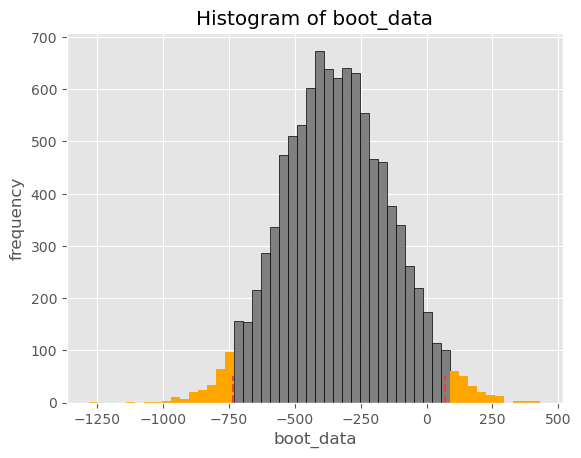

Доверительный интервал: [-734.38, 68.8]
Р-уровень значимости: 0.1


In [40]:
ARPPU_bootstrap = get_bootstrap(group_a.query('revenue>0').revenue, group_b.query('revenue>0').revenue)

Результат показал, что p-value>0,05, что означает, что мы не можем отвергнуть нулевую гипотезу. Вывод заключается в том, что по метрике ARPPU мы также не имеет стат значимых различий. 

__Какой набор предложений можно считать лучшим?__

Исходя из проведенного анализа, между контрольной и тестовой групп нет статистически значимых различий в метриках ARPU (Average revenue per user) - cредний доход с привлечённого пользователя и ARPPU (Average revenue per paying user) - cредний доход на платящего пользователя (то есть клиента), однако конверсия пользователей в клиентов в контрольной группе выше, а это статистически значимо. Однозначно сложно сказать о том, какая группа оказалась лучше, но если учесть, что конверсия в контрольной группе выше, то можно сделать вывод, что набор предложений лучше именно в ней. 

Но также можно посмотреть на то, что в тестовой группе доход является наиболее равномерным и стабильным с точки зрения бизнеса. Если с контрольной группы отвалится крупный клиент,то показатели могут сильно просесть, в отличии от тестовой группы.

### Задание 3  
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

1) DAU/MAU - для отслеживания активности пользователей;  
2) ARPU/ARPPU - доход от пользователей во время проведения события;  
3) retention - повысился ли при проведении тематического события;  
4) конверсия в пользователей, которые приняли участие в событии;  
5) кол-во пользователей завершивших событие/кол-во пользователей принявшие участие в событии;  
6) средняя продолжительность сессии (average session length, ASL).


Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Можно добавить следующие метрики:  
1) churn rate - отток пользователей, на каком этапе отваливаются большинство пользователей;  
2) какой процент пользователей возвращаются в событие после отката;  
3) число откатов по уровням. 

